In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
import seaborn as sns

#preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from collections import  Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

#wordcloud
from wordcloud import WordCloud, STOPWORDS

#stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

#embedding
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input

# col 생략 없이 출력
pd.set_option('display.max_columns', None)
# col 최대 너비 200
pd.set_option('max_colwidth', 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/NLP/NLP_study/nlp_data/practice.csv',index_col=0)
test = pd.read_csv('/content/drive/MyDrive/NLP/NLP_study/nlp_data/test.csv',index_col=0)

train.columns = ['text','author']

In [ ]:
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4
4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3


In [ ]:
pd.set_option('max_colwidth', 220) #길이를 늘려줘
test.head()

,text
index,
0,"“Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. She had a decided genius that way: witness the way in which she preser..."
1,"""No,"" replied he, with sudden consciousness, ""not to find it in YOU; for I cannot be ignorant that to you, to your goodness, I owe it all.--I feel it--I would express it if I could--but, as you well know, I am no ora..."
2,"As the lady had stated her intention of screaming, of course she would have screamed at this additional boldness, but that the exertion was rendered unnecessary by a hasty knocking at the door: which was no sooner he..."
3,“And then suddenly in the silence I heard a sound which sent my heart into my mouth. It was the clank of the levers and the swish of the leaking cylinder. He had set the engine at work. The lamp still stood upon the ...
4,"His conviction remained unchanged. So far as I know--and I believe his honest heart was transparent to me--he never wavered again, in his solemn certainty of finding her. His patience never tired. And, although I tre..."


# EDA
### 데이터에서 유의미한 값을 뽑아낼 수 있는지 확인해보자
>허구(fiction)에서 문체 또는 스타일(style)은 작품에 드러난 작가의 고유의 표현을 뜻한다.[1] 글에 드러난 비유와 같은 수사법적 특징이나 특정한 단어의 사용 빈도를 근거로 문체를 판단할 수 있다. 이러한 문체는 플롯, 등장인물, 주제, 설정과 함께 허구의 기본 구성 요소 중 하나로 간주된다.[2]

누가 쓴 글인지를 잘 분류하기 위해서는 작가마다의 특징을 뽑아내는게 중요하다.  
1. 글의 내용 (내재적)
2. 특정 단어의 빈도 (외적)
****
텍스트 데이터 시각화는 단어 빈도, 문장 길이, 평균 단어 길이 등 근본적인 특성을 보기 위해 진행한다.
## 전체

In [ ]:
train.shape, test.shape

((54879, 2), (19617, 1))

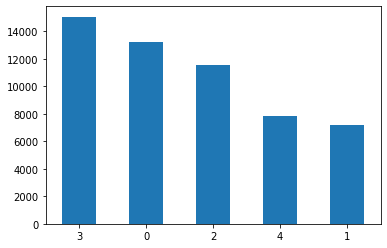

In [ ]:
#작가 별 문장수 : 데이터 불균형 확인
plt.figure()
train['author'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

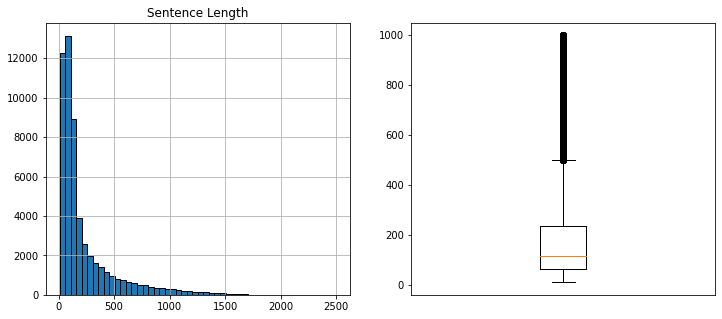

In [ ]:
#문장길이 : 패딩값을 판단
fig, axes = plt.subplots(1,2,figsize=(12,5))
plt.axes(axes[0])
train['text'].str.len().hist(bins=50, histtype='bar', edgecolor='k')
plt.title('Sentence Length')
plt.axes(axes[1])
plt.boxplot([i for i in train['text'].str.len() if i<1000]) #1000개 이하만
plt.xticks([])
plt.show()

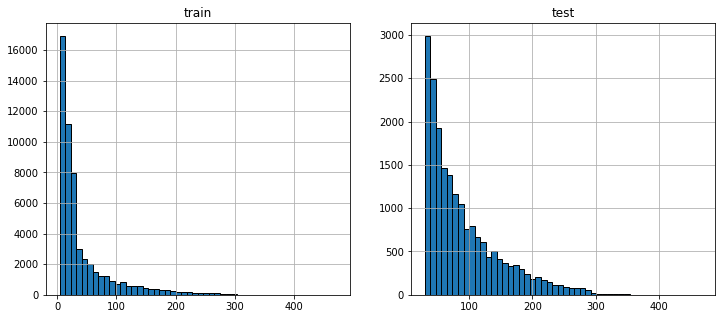

In [ ]:
# 단어 길이 분포 : 이건 왜보는거임..?
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist(bins=50, histtype='bar', edgecolor='k')
fig, axes = plt.subplots(1,2, figsize = (12,5))
plt.axes(axes[0])
plot_word_number_histogram(train['text'])
plt.title('train')
plt.axes(axes[1])
plot_word_number_histogram(test['text'])
plt.title('test')
plt.show()

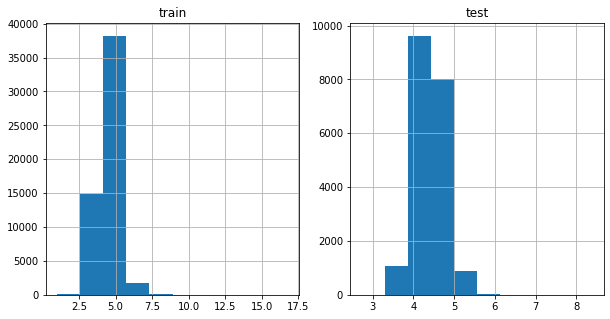

In [ ]:
# 평균 단어 길이 : 이거는 ngram 때문인가..?
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

fig, axes = plt.subplots(1,2, figsize = (10,5))
plt.axes(axes[0])
plot_word_length_histogram(train['text'])
plt.title('train')
plt.axes(axes[1])
plot_word_length_histogram(test['text'])
plt.title('test')
plt.show()

***
## 작가별 
앞에서 확인했듯이 작가 별 문장수의 불균형이 있기 때문에 보정이 필요함
### 1. 불용어 사용 빈도

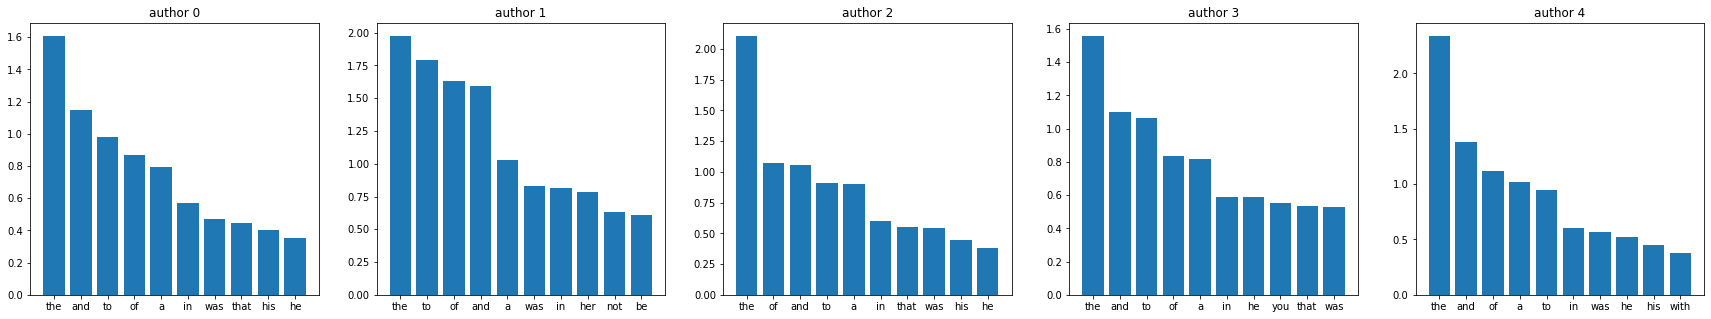

In [ ]:
# 불용어 분포 : 아마 문체를 파악하기 위함
def plot_top_stopwords_barchart(text):
    
    new= text.str.split()
    #데이터프레임의 열 값을 리스트로 반환. 단순 열 값은 인덱스와 같이 불러와지는 series로 이를 쉽게 리스트로 바꿔줌
    new=new.values.tolist() 
    corpus=[word for i in new for word in i]
    # 딕셔너리 생성 함수 가져오는 모듈
    from collections import defaultdict 
    # 기본값이 int인 딕셔너리 생성 
    #( 마치 df.column = np.nan 처럼 nan으로 초기값 설정하는것과 같음. 주로 문장 내 단어 수와 같이 개수 세는데 씀)
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    #zip(a,b)는 a,b를 묶는것이며, *연산자는 반대로 unpacking한다. 
    x,y=zip(*top) 
    #평균 문자길이로 정규화
    y = [k/len(text) for k in y] 
    plt.bar(x,y)

fig, axes = plt.subplots(1,5, figsize=(30,5))
for i in range(5):
    plt.axes(axes[i])
    plot_top_stopwords_barchart(train.loc[train['author']==i, 'text'])
    plt.title('author {}'.format(i))
plt.show()

In [ ]:
# 단어들을 제대로 보기 위한 간단한 전처리
train['new_text'] = train.text.str.split()
train['new_text'] = train['new_text'].apply(lambda x: [re.sub("[^a-zA-Z -]","",word) for word in x])
train['new_text'] = train['new_text'].apply(lambda x: [word.lower() for word in x])

### 불용어 제외 최빈단어

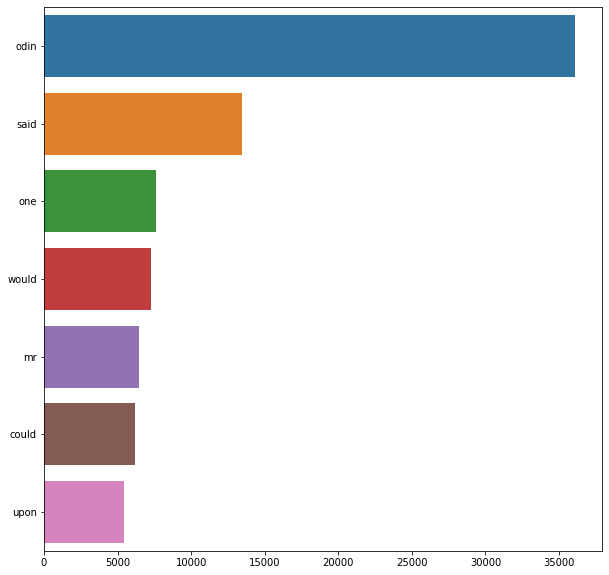

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new=text.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:60]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)

plt.figure(figsize=(10,10))
plot_top_non_stopwords_barchart(train['new_text'])  
plt.show()

#여기서 odin은 고유명사를 변환한 단어

13235
7222
11554
15063
7805


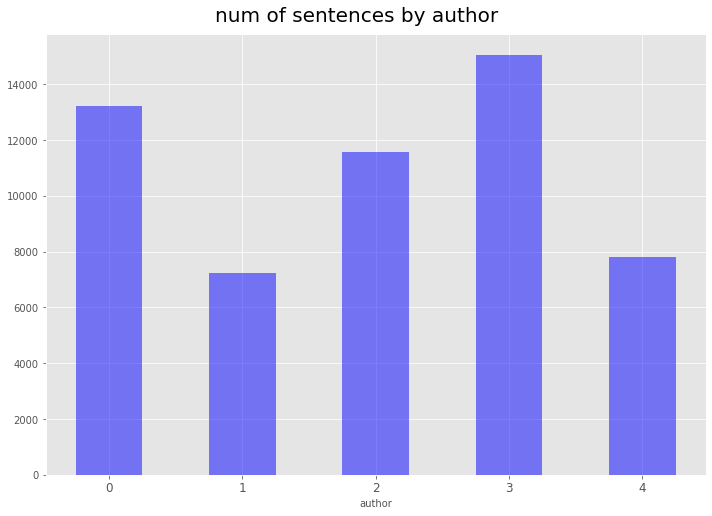

In [ ]:
for i in [0,1,2,3,4]:
    print(len(train[train['author']==i]['new_text']))
#작가 별 문장 개수

%matplotlib inline
plt.style.use("ggplot") #이거 되게 이쁘다

# 히스토그램 을 사용해서 데이터의 분포를 살펴보기.
feature = train['author']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정
plt.suptitle("num of sentences by author", fontsize=20) # 부제목과 폰트 크기 설정

plt.xlabel('author', fontsize=10) # 제목과 폰트 크기 설정
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) # 막대그래프 생성
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

### 불용어에 포함되지 않는 단어 (즉 코퍼스) 분포 - 작가별

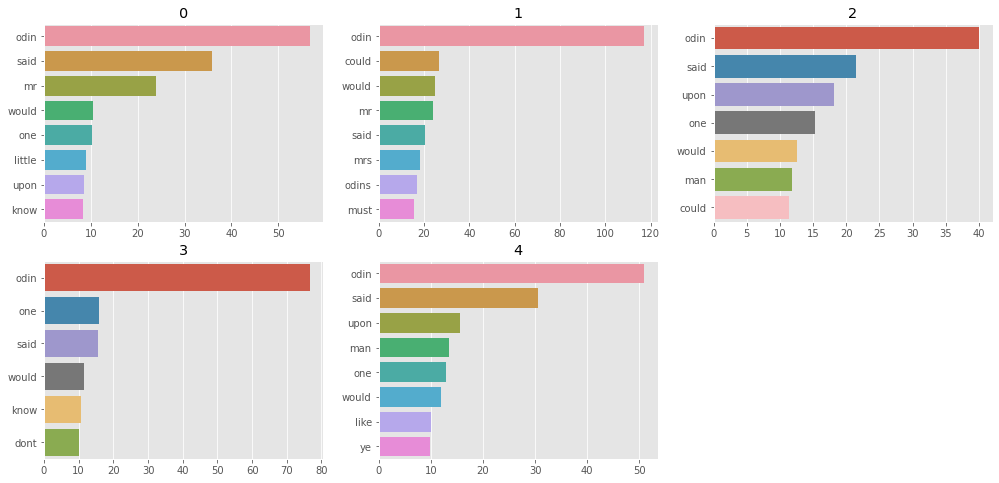

In [ ]:
fig = plt.figure(figsize=(17,8)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_non_stopwords_barchart2(text):
    stop = set(stopwords.words('english'))
    
    new = text.values.tolist()
    corpus = [word for i in new for word in i]
    #from collections import Counter
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:60]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    y = [num/len(text)*100 for  num in y]
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart2(train[train['author']==i]['new_text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

위 그래프를 통해 
1. mr는 0과 1에서 많이 쓰이는것을 알 수 있다.
2. 1은 4와 비슷한 문장길이에도 불구하고 odin이 2.5배 많이 언급됨. odin이 많이 나오면 킹리적 갓심 가능?
3. (0,2,4) (1,3) 이 유사한 문장 분포를 보임. 
4. 4번의 마지막에 ye는 무엇일까?

In [ ]:
train[train['text'].str.contains(' ye ', na = False)][['text','author']]

,text,author
index,,
86,"""Put me your hand into the corner, and see what ye find there,"" replied odin. ""Throgodin's rope is still in the brown chamber. Fare ye well.""",4
234,"“Me!” cried odin, the blood starting to his face. “I give ye the lie.”",4
244,"""And so ye go to Tunstall?"" odin inquired.",4
335,"""Brother Martin,"" he said, in a voice capitally disguised, and suited to his monkish robe, ""let us enter and seek alms from these poor sinners. _Pax vobiscum_! Ay,"" he added, in his own voice, ""'tis as I feared; I ha...",4
444,"“What!” he said, “not one word of prayer before God's own open house? How can ye hope for His blessing upon the day?”",2
...,...,...
54179,"""Nick Appleyard,"" said Hatch, ""Sir odin commends him to you, and bids that ye shall come within this hour to the Moat House, there to take command.""",4
54692,"“What would ye be, then? Woodmen? Verderers?”",2
54778,"Even when I thought of odin, and how we had parted that day forever, and when I recalled all the circumstances of our parting, and all her looks and tones, and the action of her fingers while she knitted,—even then ...",0


#### 확실히 4번에서 많이 나온다. 
#### 이거 구글에 slang으로 찾아보니까 yes의 준말 혹은  아일랜드에서 you의 복수형으로도 쓰인다고 한다.
[링크](https://www.urbandictionary.com/define.php?term=Ye)  

인사이트
1. 4번 작가의 구분 단어로 지정 >> 파생변수 생성
2. 다른 작가들이 많이 쓰는 slang이 있을까? tf-idf 변환 후 국어사전에는 나오지 않는 단어들을 찾아서 확인해보는것도 ㄱㅊ을듯
***
said는 왜 많이 나오는 것인가

In [ ]:
train[train['text'].str.contains('said', na = False)]['text']

index
2         She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by Mr. odin, she saw on ...
5                                                                                                                                                  "It was well fought," he said, "and, by my sooth, they will not charge us twice."
7        “A proper figure of a man at-arms,” said the little knight. “Why, man, you are no chicken, yet I warrant him the stronger man. See to that great stone from the coping which hath fodin upon the bridge. Four of my lazy...
8                                                                                                                                                                                    'You were not here last Sunday night,' he said.
14                                                                            

In [ ]:
print(train[train['text'].str.contains('said', na = False)].groupby('author').size(),'\n')
print('said 가 포함된 문장 / 작가 별 전체 문장')
for cnt, i in enumerate(np.array(train[train['text'].str.contains('said', na = False)].groupby('author').size()) / [13235,7222,11554,15063,7805]):
    print(cnt,':', round(i*100),'% ')

author
0    4542
1    1439
2    2410
3    2165
4    2310
dtype: int64 

said 가 포함된 문장 / 작가 별 전체 문장
0 : 34 % 
1 : 20 % 
2 : 21 % 
3 : 14 % 
4 : 30 % 


### 작가 별 평균 문장길이 

In [ ]:
train['sent_len'] = train.new_text.apply(len)

In [ ]:
train.groupby('author').sent_len.mean().round() # 평균 문장 길이는 유의미한 차이가 있는지는 잘 모르게씀. 분포를 보자

author
0    37.0
1    57.0
2    40.0
3    41.0
4    42.0
Name: sent_len, dtype: float64

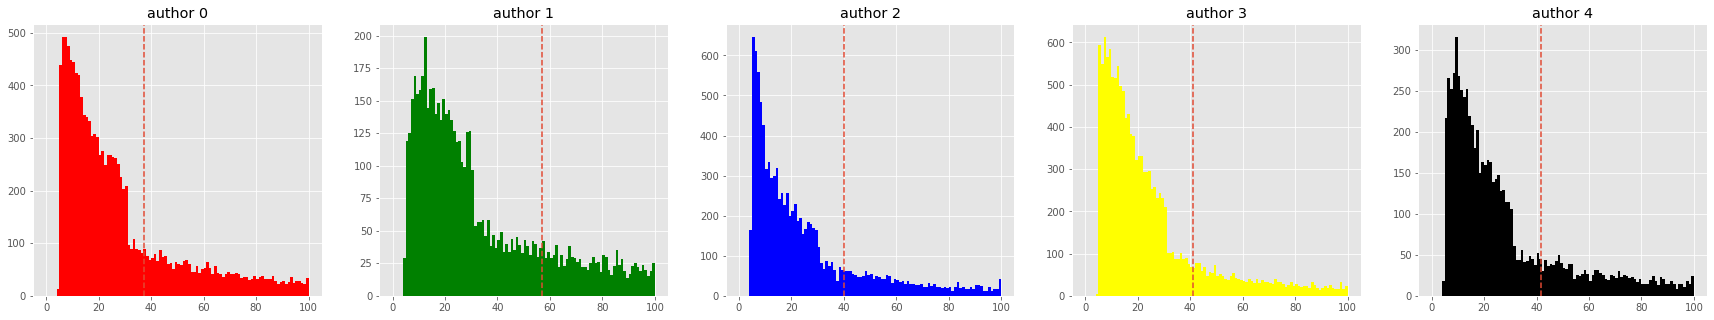

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(30,5))
colors = ["red", "green", "blue", "yellow",'black']
for i in range(5):
    plt.axes(axes[i])
    plt.hist(train[train.author==i].sent_len, color=colors[i],bins=100, range=(0,100))
    plt.axvline(x=train[train.author==i].sent_len.mean(), linestyle='--')
    plt.title('author {}'.format(i))
plt.show()

# 단순히 문장의 개수가 적어서 차이나는 것이므로 유의미하지 않은 지표

## n-gram 시각화
자주 쓰는 단어 와 유사하게 작가마다 자주 쓰는 구 도 있을지 모른다. 확인해보자  
#### ex) can I ? , what the..

In [ ]:
train['clean_text'] = train.new_text.apply(lambda x:" ".join(x))

In [ ]:
def plot_top_ngrams_barchart(text, n=2):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

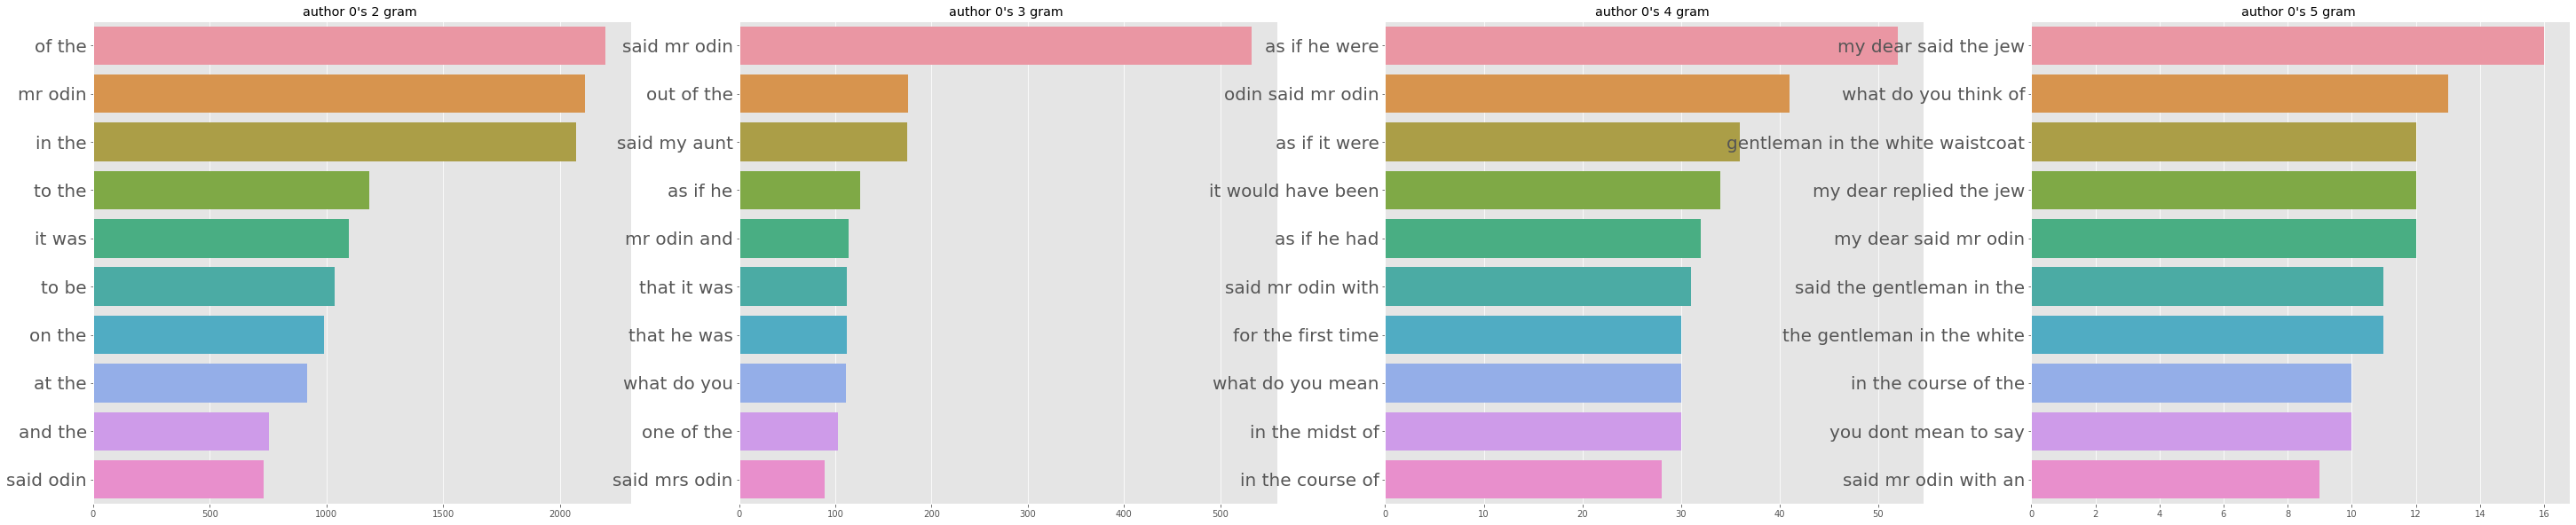

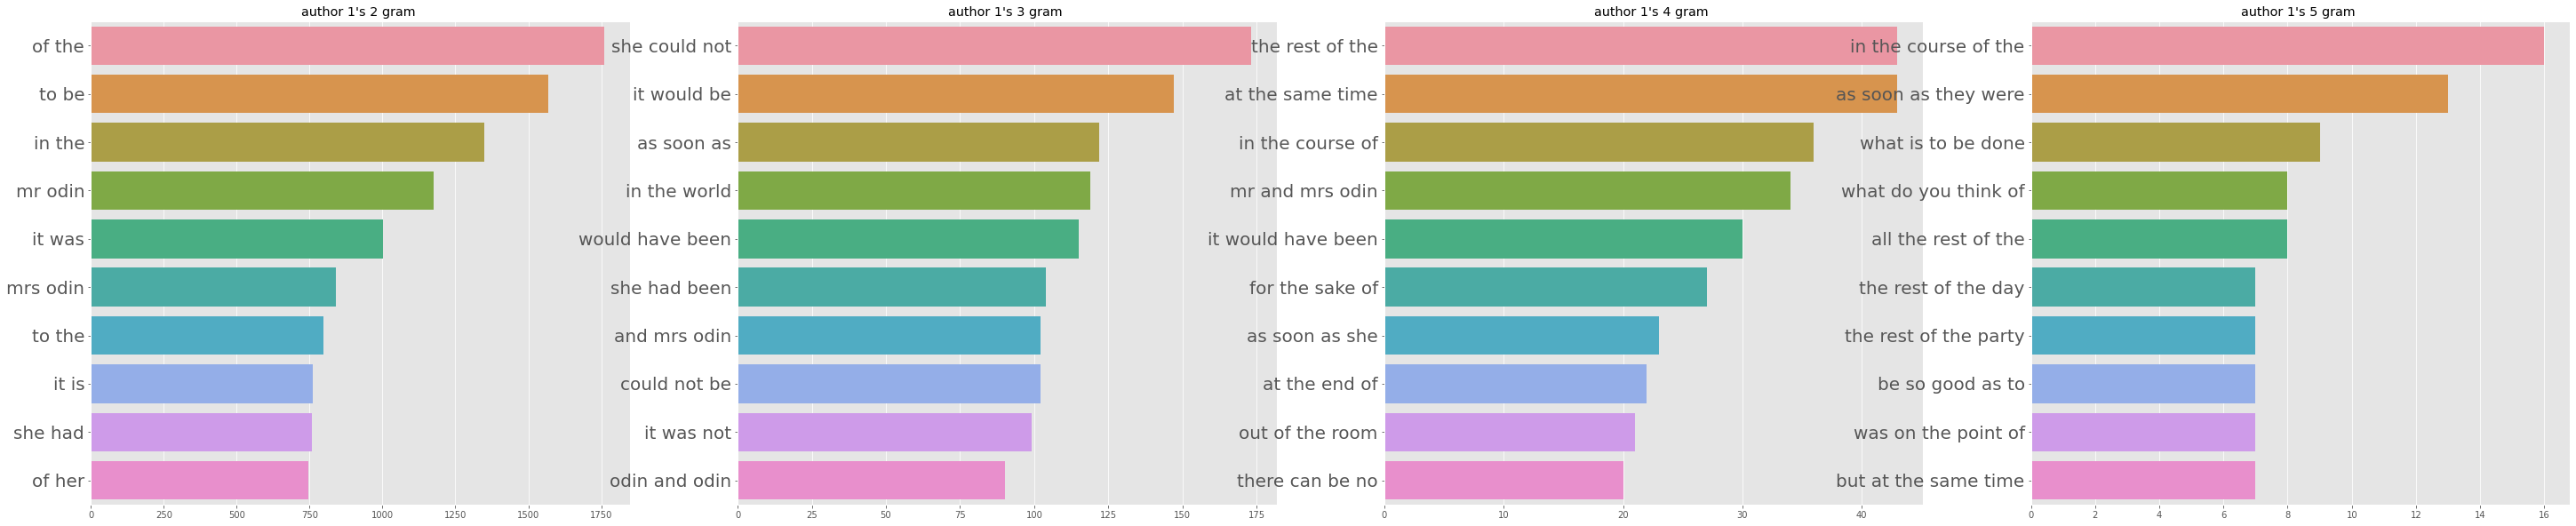

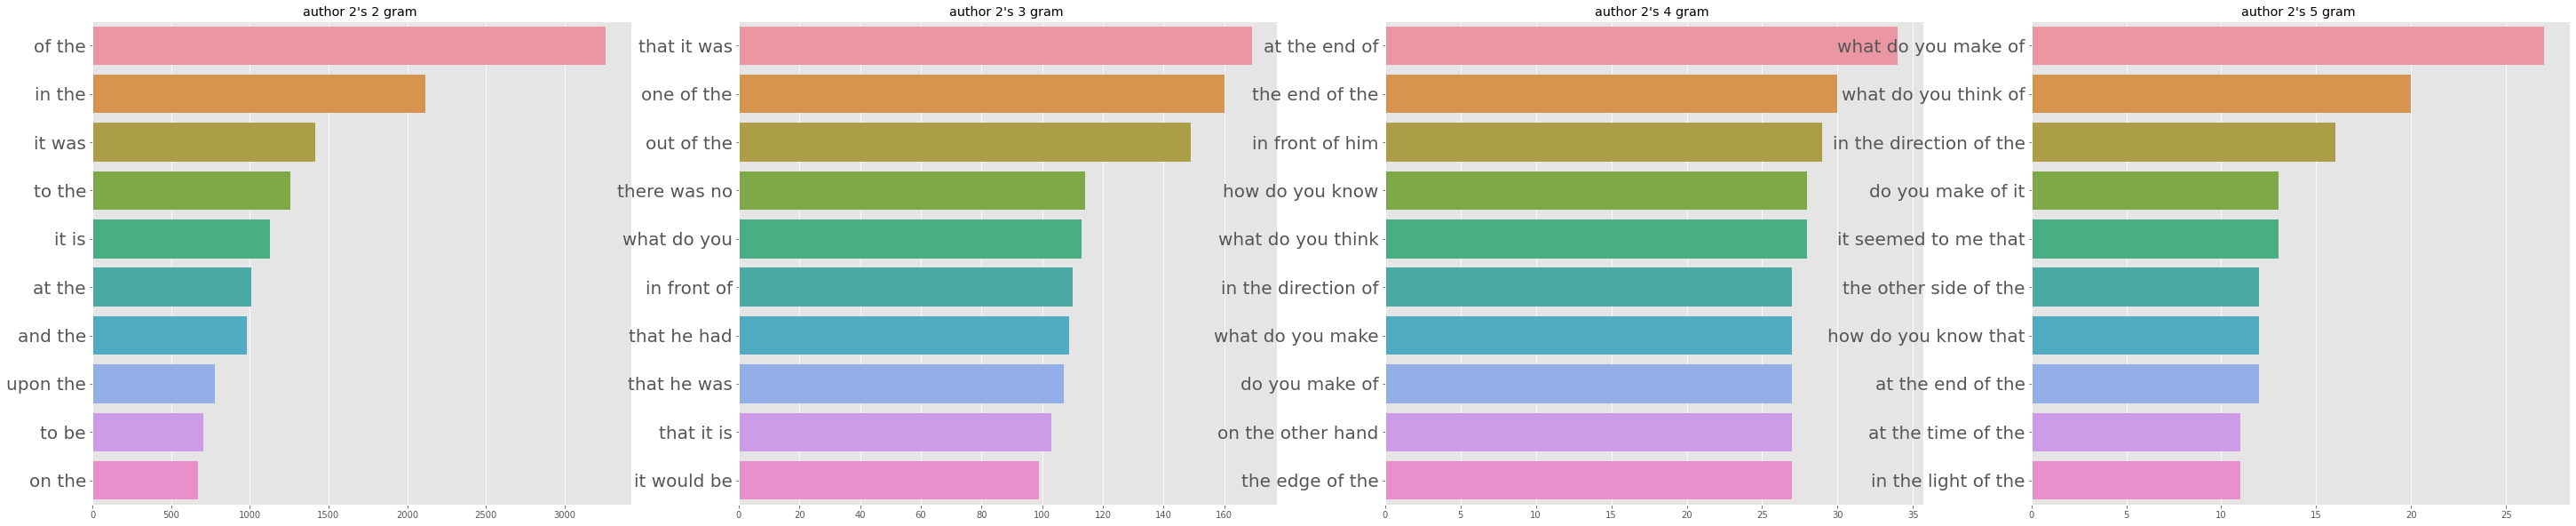

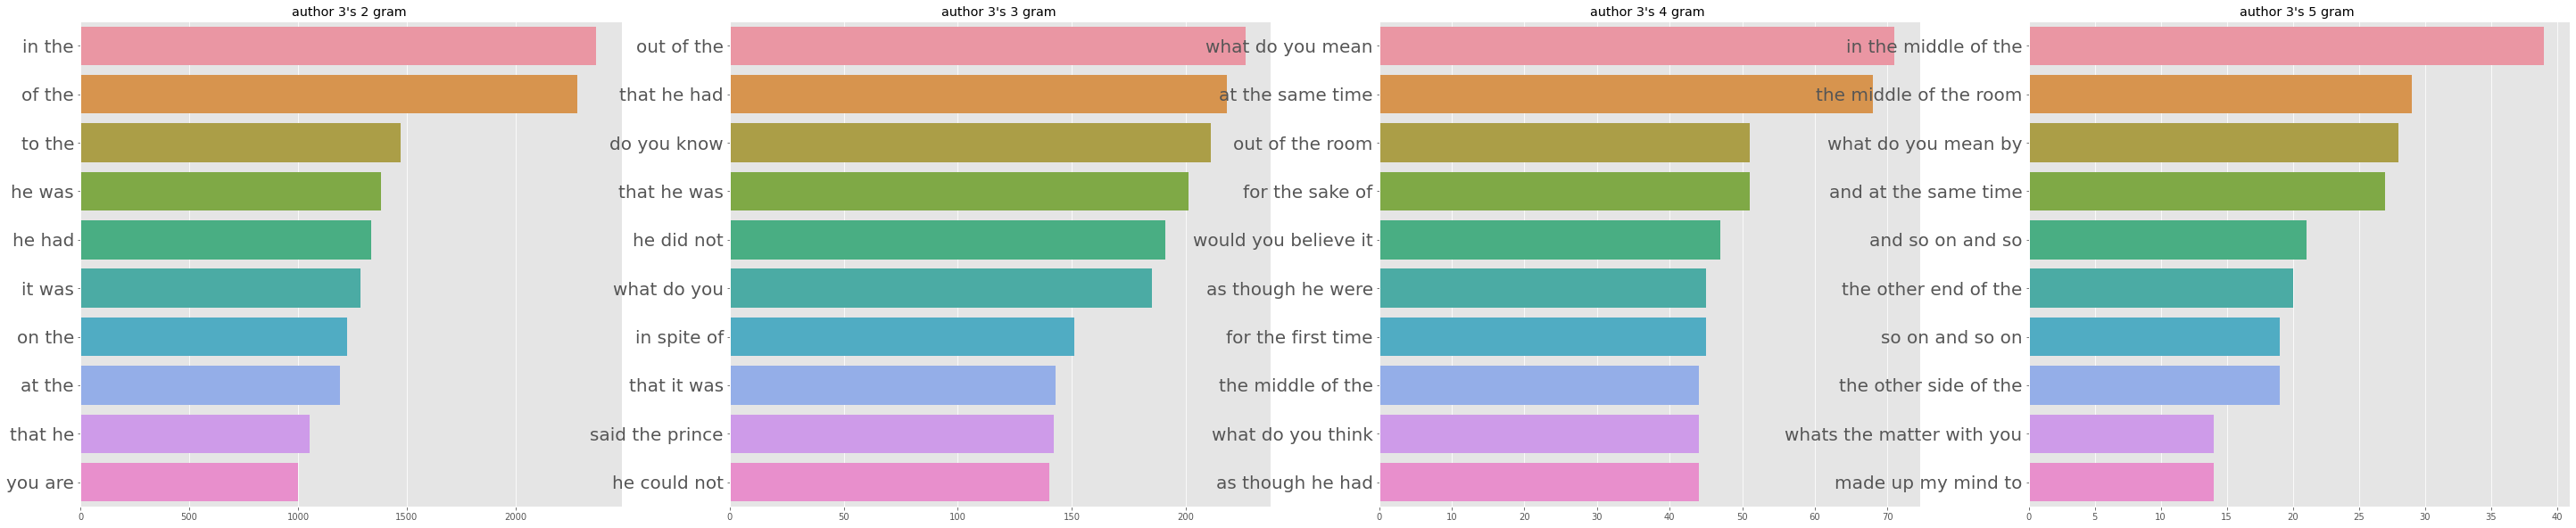

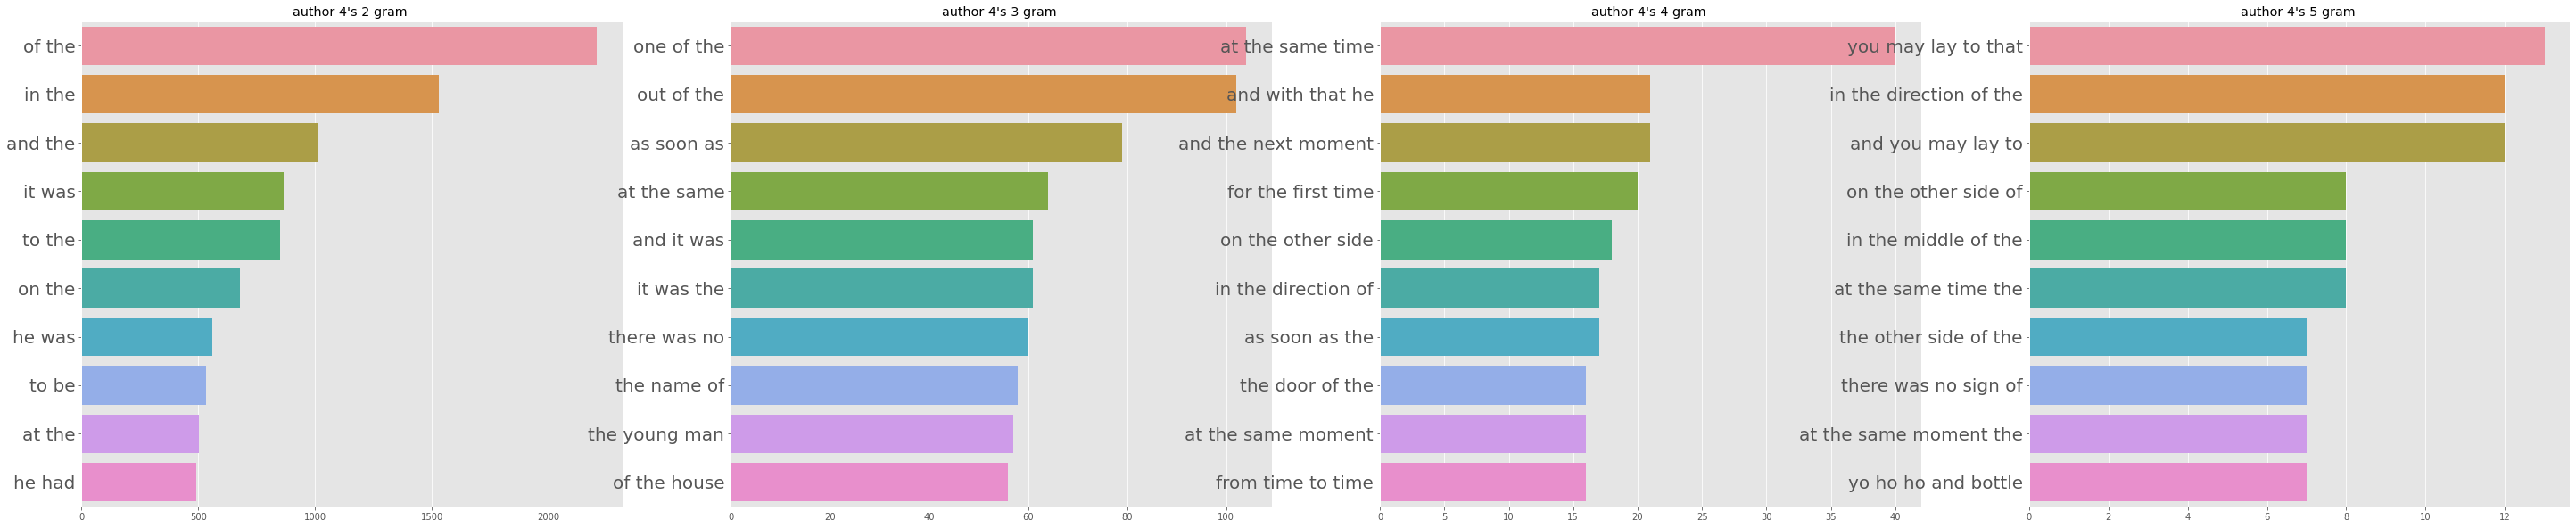

In [ ]:
plt.rc('ytick', labelsize=20)
for k in range(5):
    fig, axes = plt.subplots(1,4, figsize=(50,10))
    for i in [2,3,4,5]:
        plt.axes(axes[i-2])
        plot_top_ngrams_barchart(train[train['author']==k]['clean_text'],i)
        plt.title("author {0}'s {1} gram ".format(k, i))

# 생각만큼 뚜렷하게 나오지 않음

In [ ]:
def plot_top_ngrams_barchart2(text, n=2):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram2(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram2(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    return x, y

In [ ]:
# tri-gram에서 겹치지 않는 단어 확인
for i in range(5):
    x,y = plot_top_ngrams_barchart2(train[train['author']==i]['text'],3)
    globals()[f'set{i}'] = set(x)

print("author 0 : ", set0 - (set1|set2|set3|set4))
print("author 1 : ", set1 - (set0|set2|set3|set4))
print("author 2 : ", set2 - (set0|set1|set3|set4))
print("author 3 : ", set3 - (set0|set1|set2|set4))
print("author 4 : ", set4 - (set0|set1|set2|set3))

author 0 :  {'said mr odin', 'as if he', 'mr odin and', 'said my aunt', 'to mr odin'}
author 1 :  {'odin and odin', 'it was not', 'would have been', 'and mrs odin', 'she could not', 'she had been', 'could not be', 'in the world'}
author 2 :  {'that it is', 'in front of'}
author 3 :  {'do you know', 'he could not', 'in spite of', 'said the prince', 'he did not'}
author 4 :  {'the young man', 'at the same', 'it was the', 'and it was', 'the name of', 'of the house'}


In [ ]:
train

,text,author,new_text,sent_len,clean_text
index,,,,,
0,"he was almost choking. there was so much, so much he wanted to say, but strange exclamations were all that came from his lips. the pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and wa...",3,"[he, was, almost, choking, there, was, so, much, so, much, he, wanted, to, say, but, strange, exclamations, were, all, that, came, from, his, lips, the, pole, gazed, fixedly, at, him, at, the, bundle, of, notes, in, ...",46,he was almost choking there was so much so much he wanted to say but strange exclamations were all that came from his lips the pole gazed fixedly at him at the bundle of notes in his hand looked at odin and was in ev...
1,"“your sister asked for it, i suppose?”",2,"[your, sister, asked, for, it, i, suppose]",7,your sister asked for it i suppose
2,"she was engaged one day as she walked, in perusing jane’s last letter, and dwelling on some passages which proved that jane had not written in spirits, when, instead of being again surprised by mr. odin, she saw on ...",1,"[she, was, engaged, one, day, as, she, walked, in, perusing, janes, last, letter, and, dwelling, on, some, passages, which, proved, that, jane, had, not, written, in, spirits, when, instead, of, being, again, surpris...",57,she was engaged one day as she walked in perusing janes last letter and dwelling on some passages which proved that jane had not written in spirits when instead of being again surprised by mr odin she saw on looking ...
3,"the captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. he turned and spoke to us, “doctor's watch on the lookout. dr. odin take the north side, if you pl...",4,"[the, captain, was, in, the, porch, keeping, himself, carefully, out, of, the, way, of, a, treacherous, shot, should, any, be, intended, he, turned, and, spoke, to, us, doctors, watch, on, the, lookout, dr, odin, tak...",58,the captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended he turned and spoke to us doctors watch on the lookout dr odin take the north side if you please jim ...
4,"“have mercy, gentlemen!” odin flung up his hands. “don’t write that, anyway; have some shame. here i’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds in both halves.... ...",3,"[have, mercy, gentlemen, odin, flung, up, his, hands, dont, write, that, anyway, have, some, shame, here, ive, torn, my, heart, asunder, before, you, and, you, seize, the, opportunity, and, are, fingering, the, wound...",39,have mercy gentlemen odin flung up his hands dont write that anyway have some shame here ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both halves oh my god
...,...,...,...,...,...
54874,"“is that you, mr. smith?” odin whispered. “i hardly dared hope that you would come.”",2,"[is, that, you, mr, smith, odin, whispered, i, hardly, dared, hope, that, you, would, come]",15,is that you mr smith odin whispered i hardly dared hope that you would come
54875,"i told my plan to the captain, and between us we settled on the details of its accomplishment.",4,"[i, told, my, plan, to, the, captain, and, between, us, we, settled, on, the, details, of, its, accomplishment]",18,i told my plan to the captain and between us we settled on the details of its accomplishment
54876,"""your sincere well-wisher, friend, and sister, ""lucy odin.",1,"[your, sincere, well-wisher, friend, and, sister, lucy, odin]",8,your sincere well-wisher friend and sister lucy odin


# 추가적인 전처리 후 시각화
1. 불용어 처리 (특정 명사나 고유명사를 찾기 위함) 후 워드클라우드
2. tf-idf 빈도 임베딩 후 워드클라우드

In [ ]:
# additional data cleaning
# 이 함수를 test에도 적용하면 됨

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub("[^a-zA-Z -]","",texts[i]) #대괄호 내 문자들을 제외한 모든 문자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    review = re.sub(r'"+', ' ', review) #spaces 제거   
    review = re.sub('-{2,}', ' ', review) #-이 2번이상 반복되면 제거   

    corpus.append(review) 
  
  return corpus

In [ ]:
temp = clean_text(train['text'])
train['clean_text'] = temp

temp = clean_text(test['text'])
test['clean_text'] = temp

test.head() #깨끗함

,text,clean_text
index,,
0,not at all i think she is one of the most charming young ladies i ever met and might have been most useful in such work as we have been doing she had a decided genius that way witness the way in which she preserved t...,not at all i think she is one of the most charming young ladies i ever met and might have been most useful in such work as we have been doing she had a decided genius that way witness the way in which she preserved t...
1,no replied he with sudden consciousness not to find it in you for i cannot be ignorant that to you to your goodness i owe it all i feel it i would express it if i could but as you well know i am no orator,no replied he with sudden consciousness not to find it in you for i cannot be ignorant that to you to your goodness i owe it all i feel it i would express it if i could but as you well know i am no orator
2,as the lady had stated her intention of screaming of course she would have screamed at this additional boldness but that the exertion was rendered unnecessary by a hasty knocking at the door which was no sooner heard...,as the lady had stated her intention of screaming of course she would have screamed at this additional boldness but that the exertion was rendered unnecessary by a hasty knocking at the door which was no sooner heard...
3,and then suddenly in the silence i heard a sound which sent my heart into my mouth it was the clank of the levers and the swish of the leaking cylinder he had set the engine at work the lamp still stood upon the floo...,and then suddenly in the silence i heard a sound which sent my heart into my mouth it was the clank of the levers and the swish of the leaking cylinder he had set the engine at work the lamp still stood upon the floo...
4,his conviction remained unchanged so far as i know and i believe his honest heart was transparent to me he never wavered again in his solemn certainty of finding her his patience never tired and although i trembled f...,his conviction remained unchanged so far as i know and i believe his honest heart was transparent to me he never wavered again in his solemn certainty of finding her his patience never tired and although i trembled f...


### wordcloud

In [ ]:
# 추가
stop = stopwords.words('english')
stop.append('odin')
stop.append('say')
stop.append('dont')
stop = set(stop)

In [ ]:
def plot_wordcloud_noun(text,tags=['NN','NNP']):
    

    def _preprocess_text(text,tags):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            
            tagged = nltk.pos_tag(words)
            allnoun = [word for word, pos in tagged if pos in tags]

            corpus.append(allnoun)
        return corpus
    
    corpus=_preprocess_text(text,tags)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

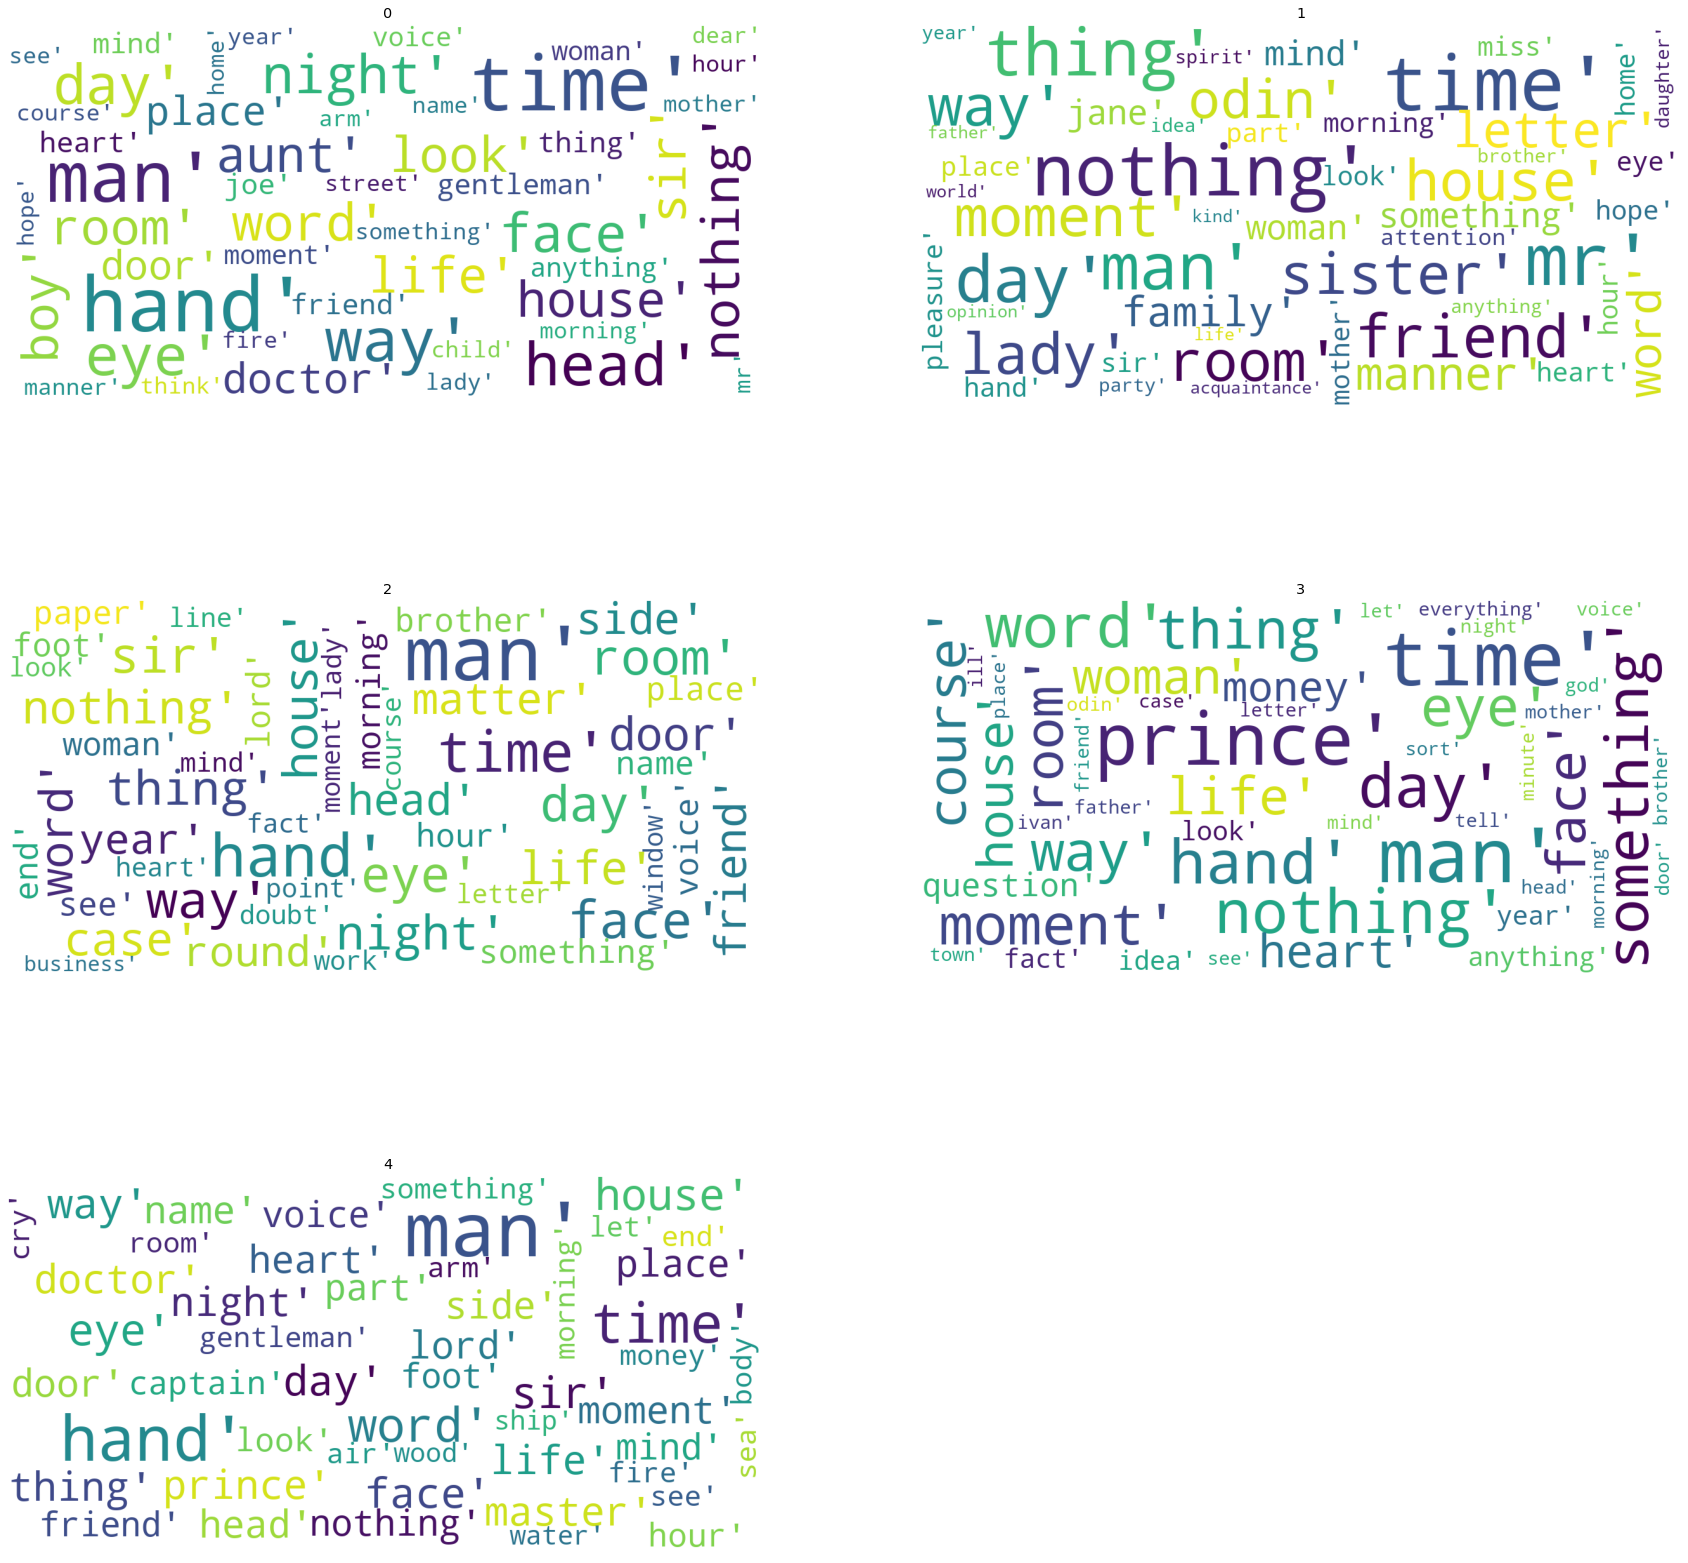

In [ ]:
fig = plt.figure(figsize=(30,30))
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author']==i]['clean_text'], ['NN','NNP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

뭐가 엄청 잘 보이지는 않지만 3번에 prince가 많은것을 확인
***
### TF-IDF 진행 후 다시 한번 그려본다

In [ ]:
# 개별 문장들을 작가마다 하나로 합치는 코드1
corpus_by_author = []
for num in range(5):
    corpus_by_author.append([i for i in train[train['author']==num]['clean_text']])

In [ ]:
# 개별 문장들을 작가마다 하나로 합치는 코드2
corpus_all = []
tags=['NN','NNP']

for i in range(5):
    words = " ".join(corpus_by_author[i])
    words = words.split()
    tagged = nltk.pos_tag(words)
    allnoun = [word for word, pos in tagged if pos in tags]
    words = " ".join(allnoun)
    corpus_all.append(words)

## tfidf에서 여러가지 방법을 써본다
1. 기본
2. max_df < 5 : 모든 문서에서 나온 단어는 빼고 벡터화
3. ngram_range (1,2)

In [ ]:
tfidf1 = TfidfVectorizer(stop_words=stop,lowercase=True)
tfidf2 = TfidfVectorizer(stop_words=stop,lowercase=True, max_df=4)
tfidf3 = TfidfVectorizer(stop_words=stop,lowercase=True, ngram_range=(2,4))

In [ ]:
tfidf_vectorizer = tfidf1.fit_transform(corpus_all) 

tfidf_dict = tfidf1.get_feature_names()   
author_df = pd.DataFrame(tfidf_vectorizer.toarray(),columns=tfidf_dict)
print(author_df.shape)
for i in range(5):
    print(author_df.iloc[i,:].nlargest(5))

fig = plt.figure(figsize=(20,20))
rows = 3
cols = 2

for i in range(5):
    # 가장 많이 나온 단어부터 50개를 저장한다.
    cnt_cloud = author_df.iloc[i,:].nlargest(50)

    # WordCloud를 생성한다.
    wc = WordCloud(background_color="white", max_font_size=50)
    cloud = wc.generate_from_frequencies(dict(cnt_cloud))

    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(cloud)

(5, 18146)
mr      0.373049
time    0.265593
man     0.240668
hand    0.201895
head    0.188878
Name: 0, dtype: float64
mr         0.324048
time       0.264970
mrs        0.258602
nothing    0.238084
man        0.181481
Name: 1, dtype: float64
man     0.456271
time    0.214696
face    0.190141
room    0.183172
way     0.174213
Name: 2, dtype: float64
prince       0.328033
man          0.308807
time         0.277927
nothing      0.207547
something    0.201563
Name: 3, dtype: float64
man      0.456930
time     0.230608
hand     0.219892
house    0.181743
ye       0.157612
Name: 4, dtype: float64


(5, 18146)
mr      0.373049
time    0.265593
man     0.240668
hand    0.201895
head    0.188878
Name: 0, dtype: float64
mr         0.324048
time       0.264970
mrs        0.258602
nothing    0.238084
man        0.181481
Name: 1, dtype: float64
man     0.456271
time    0.214696
face    0.190141
room    0.183172
way     0.174213
Name: 2, dtype: float64
prince       0.328033
man          0.308807
time         0.277927
nothing      0.207547
something    0.201563
Name: 3, dtype: float64
man      0.456930
time     0.230608
hand     0.219892
house    0.181743
ye       0.157612
Name: 4, dtype: float64


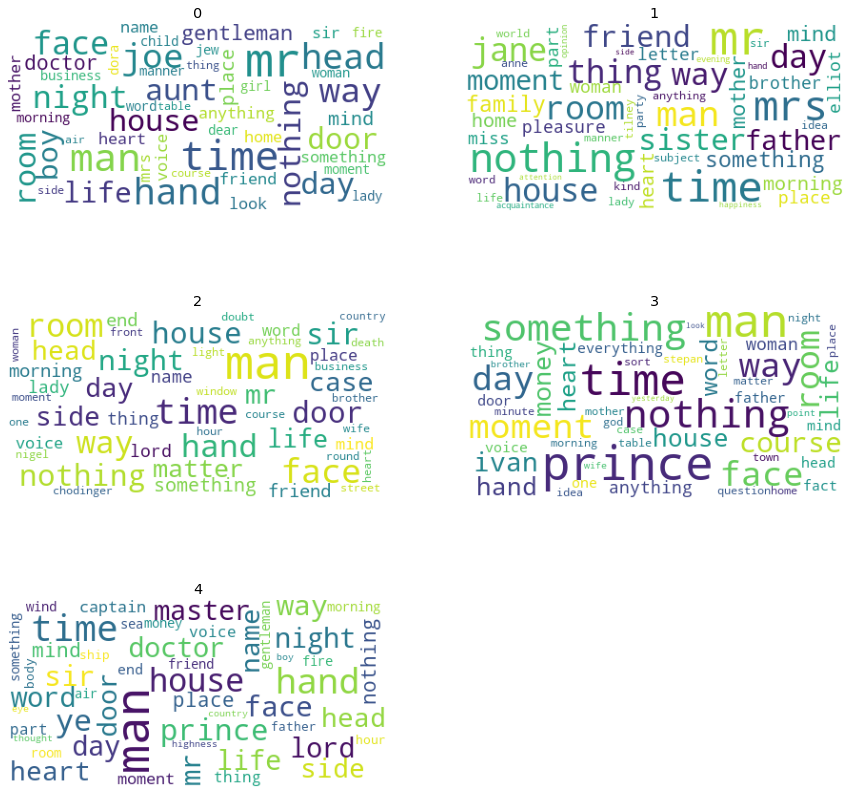

In [ ]:
tfidf_vectorizer = tfidf1.fit_transform(corpus_all) 

tfidf_dict = tfidf1.get_feature_names()   
author_df = pd.DataFrame(tfidf_vectorizer.toarray(),columns=tfidf_dict)
print(author_df.shape)
for i in range(5):
    print(author_df.iloc[i,:].nlargest(5))

fig = plt.figure(figsize=(15,15))
rows = 3
cols = 2

for i in range(5):
    # 가장 많이 나온 단어부터 50개를 저장한다.
    cnt_cloud = author_df.iloc[i,:].nlargest(50)

    # WordCloud를 생성한다.
    wc = WordCloud(background_color="white", max_font_size=50)
    cloud = wc.generate_from_frequencies(dict(cnt_cloud))

    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(cloud)

(5, 16079)
joe          0.580933
jew          0.237728
dora         0.222596
pip          0.188959
wickfield    0.181948
Name: 0, dtype: float64
jane        0.558271
elliot      0.310110
anne        0.293807
tilney      0.275970
highbury    0.142252
Name: 1, dtype: float64
chodinger    0.270503
nigel        0.248193
professor    0.208956
inspector    0.202672
dr           0.180676
Name: 2, dtype: float64
prince        0.819924
ivan          0.316437
stepan        0.165753
sofa          0.099042
podincutor    0.098270
Name: 3, dtype: float64
ye          0.497634
prince      0.472032
highness    0.159777
ay          0.155211
hill        0.112008
Name: 4, dtype: float64


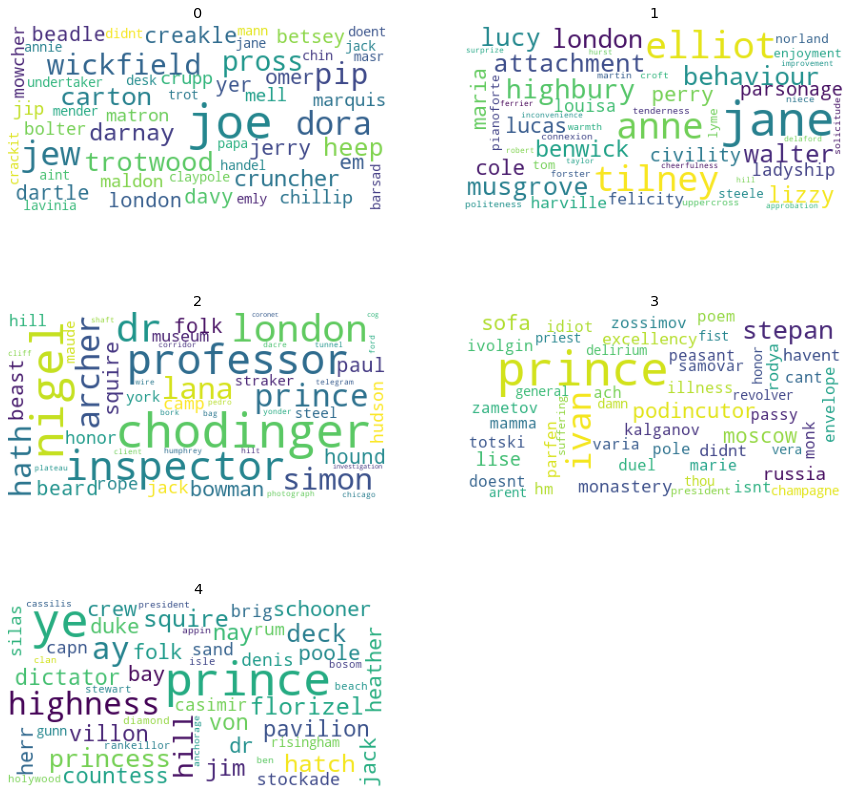

In [ ]:
tfidf_vectorizer = tfidf2.fit_transform(corpus_all) 

tfidf_dict = tfidf2.get_feature_names()   
author_df = pd.DataFrame(tfidf_vectorizer.toarray(),columns=tfidf_dict)
print(author_df.shape)
for i in range(5):
    print(author_df.iloc[i,:].nlargest(5))

fig = plt.figure(figsize=(15,15))
rows = 3
cols = 2

for i in range(5):
    # 가장 많이 나온 단어부터 50개를 저장한다.
    cnt_cloud = author_df.iloc[i,:].nlargest(50)

    # WordCloud를 생성한다.
    wc = WordCloud(background_color="white", max_font_size=50)
    cloud = wc.generate_from_frequencies(dict(cnt_cloud))

    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(cloud)

(5, 941370)
mr cruncher    0.080107
mr mell        0.056075
dear jew       0.052070
mr pip         0.048064
ha ha          0.046259
Name: 0, dtype: float64
mr mrs             0.068815
mrs smith          0.062175
sir walter         0.058382
drawing room       0.050075
captain benwick    0.049041
Name: 1, dtype: float64
professor chodinger    0.061168
sir nigel              0.055051
st paul                0.040779
dr lana                0.038740
st simon               0.034662
Name: 2, dtype: float64
ha ha             0.047872
man man           0.039590
nothing prince    0.038086
prince prince     0.038086
middle room       0.036673
Name: 3, dtype: float64
prince florizel    0.059360
moat house         0.042047
sir captain        0.033923
spy glass          0.029680
ben gunn           0.027207
Name: 4, dtype: float64


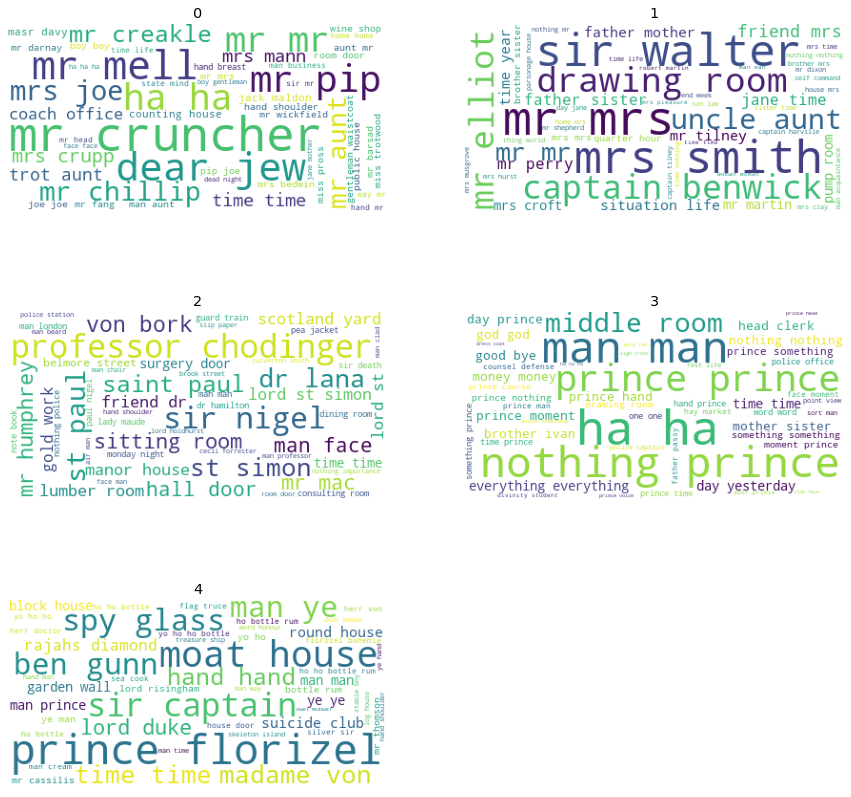

In [ ]:
tfidf_vectorizer = tfidf3.fit_transform(corpus_all) 

tfidf_dict = tfidf3.get_feature_names()   
author_df = pd.DataFrame(tfidf_vectorizer.toarray(),columns=tfidf_dict)
print(author_df.shape)
for i in range(5):
    print(author_df.iloc[i,:].nlargest(5))

fig = plt.figure(figsize=(15,15))
rows = 3
cols = 2

for i in range(5):
    # 가장 많이 나온 단어부터 50개를 저장한다.
    cnt_cloud = author_df.iloc[i,:].nlargest(50)

    # WordCloud를 생성한다.
    wc = WordCloud(background_color="white", max_font_size=50)
    cloud = wc.generate_from_frequencies(dict(cnt_cloud))

    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(cloud)

#### ye 와 마찬가지로 joe, jane, prince 정도가 눈에 띈다
***
# 최종 정리
문장의 외형으로는 문체를 구분할 수 있는 특성을 찾지 못함.  
위에서 찾은 특정 단어들의 존재 유무정도를 활용하면 될듯.
***
# 임베딩

In [ ]:
train.head()

,text,author,new_text,sent_len,clean_text
index,,,,,
0,he was almost choking there was so much so much he wanted to say but strange exclamations were all that came from his lips the pole gazed fixedly at him at the bundle of notes in his hand looked a...,3,"[he, was, almost, choking, there, was, so, much, so, much, he, wanted, to, say, but, strange, exclamations, were, all, that, came, from, his, lips, the, pole, gazed, fixedly, at, him, at, the, bun...",46,he was almost choking there was so much so much he wanted to say but strange exclamations were all that came from his lips the pole gazed fixedly at him at the bundle of notes in his hand looked a...
1,your sister asked for it i suppose,2,"[your, sister, asked, for, it, i, suppose]",7,your sister asked for it i suppose
2,she was engaged one day as she walked in perusing janes last letter and dwelling on some passages which proved that jane had not written in spirits when instead of being again surprised by mr odin...,1,"[she, was, engaged, one, day, as, she, walked, in, perusing, janes, last, letter, and, dwelling, on, some, passages, which, proved, that, jane, had, not, written, in, spirits, when, instead, of, b...",57,she was engaged one day as she walked in perusing janes last letter and dwelling on some passages which proved that jane had not written in spirits when instead of being again surprised by mr odin...
3,the captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended he turned and spoke to us doctors watch on the lookout dr odin take the north sid...,4,"[the, captain, was, in, the, porch, keeping, himself, carefully, out, of, the, way, of, a, treacherous, shot, should, any, be, intended, he, turned, and, spoke, to, us, doctors, watch, on, the, lo...",58,the captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended he turned and spoke to us doctors watch on the lookout dr odin take the north sid...
4,have mercy gentlemen odin flung up his hands dont write that anyway have some shame here ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both hal...,3,"[have, mercy, gentlemen, odin, flung, up, his, hands, dont, write, that, anyway, have, some, shame, here, ive, torn, my, heart, asunder, before, you, and, you, seize, the, opportunity, and, are, f...",39,have mercy gentlemen odin flung up his hands dont write that anyway have some shame here ive torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both hal...


In [ ]:
X_train = np.array([x for x in train['clean_text']])
X_test = np.array([x for x in test['clean_text']])
y_train = np.array([x for x in train['author']])

In [ ]:
#파라미터 설정
vocab_size = 5000
embedding_dim = 300
max_length = 100
padding_type='post'
#oov_tok = "<OOV>"

#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', 
                                                                 binary=True)
                                                                 #limit=1000000)

print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (3000000, 300)


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
tokenizer.word_index

In [ ]:
count=0

for word, index in tokenizer.word_index.items():
    count+=1
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index-1] = vector_value
    if count == 5000:
        break

In [ ]:
print('단어 nice의 맵핑된 정수 :', tokenizer.word_index['nice'])
print(embedding_matrix[tokenizer.word_index['nice']-1]==word2vec_model['nice'])

단어 nice의 맵핑된 정수 : 1581
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  Tr

In [ ]:
model = Sequential()
model.add(Input(shape=(max_length,), dtype='int32'))
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          1500000   
                                                                 
 dense_3 (Dense)             (None, 100, 64)           19264     
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                204832    
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,724,129
Trainable params: 224,129
Non-trainable params: 1,500,000
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 5
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

Epoch 1/5
1372/1372 - 23s - loss: 0.0000e+00 - acc: 0.1310 - val_loss: 0.0000e+00 - val_acc: 0.1340 - 23s/epoch - 16ms/step
Epoch 2/5
1372/1372 - 20s - loss: 0.0000e+00 - acc: 0.1310 - val_loss: 0.0000e+00 - val_acc: 0.1340 - 20s/epoch - 14ms/step
Epoch 3/5
1372/1372 - 21s - loss: 0.0000e+00 - acc: 0.1310 - val_loss: 0.0000e+00 - val_acc: 0.1340 - 21s/epoch - 16ms/step
Epoch 4/5
1372/1372 - 19s - loss: 0.0000e+00 - acc: 0.1310 - val_loss: 0.0000e+00 - val_acc: 0.1340 - 19s/epoch - 14ms/step
Epoch 5/5
1372/1372 - 21s - loss: 0.0000e+00 - acc: 0.1310 - val_loss: 0.0000e+00 - val_acc: 0.1340 - 21s/epoch - 15ms/step


In [ ]:
#파인튜닝
model = Sequential()
model.add(Input(shape=(max_length,), dtype='int32'))
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=True)
model.add(e)
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# model summary
print(model.summary())

대충 만든 모델이라 학습이 되지 않음을 알 수 있다. 사실 이러면 파인튜닝하는 의미가 없다

In [ ]:
# fit model
num_epochs = 5
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)